<a href="https://colab.research.google.com/github/dfreire770/dq-ddq-smb-agent/blob/main/Mario_Test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a modified version of the DQN tutorial from here:

https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=jbY4yrjTEyc9

But, instead of Cartpole, it uses Super Mario Bros.

The purpose of this is simply for an initial test of whether the DQN method can be used here in this fashion.

In [1]:

!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install tf-keras

!pip install gym==0.26.2
!pip install gym-notices==0.0.8
!pip install gymnasium==0.29.1
!pip install gym-super-mario-bros==7.4.0
!pip install moviepy
!pip install ffmpeg-python==0.2.0

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,756 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,036 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 4,021 kB in 2s (2,316 kB/s)
Reading package lists... Done
Reading p

This is a modified version of the DQN tutorial from here:

https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=jbY4yrjTEyc9

But, instead of Cartpole, it uses Super Mario Bros

In [2]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common


import gym_super_mario_bros
import gym.wrappers
import gym
import cv2
import os
import numpy as np
import glob
import gym.spaces as spaces

from IPython.display import HTML
from IPython.display import Video
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY, COMPLEX_MOVEMENT
from nes_py.wrappers import JoypadSpace
from base64 import b64encode

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec

from gymnasium.wrappers import FlattenObservation

In [4]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [5]:
tf.version.VERSION

'2.15.0'

In [6]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [7]:
class GymWrapper(py_environment.PyEnvironment):
    def __init__(self, gym_env):
        super(GymWrapper, self).__init__()
        self._gym_env = gym_env
        self._action_spec = self._get_action_spec()
        self._observation_spec = self._get_observation_spec()
    def _get_action_spec(self):
        action_space = self._gym_env.action_space
        if isinstance(action_space, gym.spaces.Box):
            return array_spec.BoundedArraySpec(
                shape=action_space.shape,
                dtype=action_space.dtype,
                minimum=action_space.low,
                maximum=action_space.high
            )
        elif isinstance(action_space, gym.spaces.Discrete):
            return array_spec.BoundedArraySpec(
                shape=(),
                dtype=action_space.dtype,
                minimum=0,
                maximum=action_space.n-1
            )
        else:
            raise ValueError(f"Unsupported action space type: {type(action_space)}")

    def _get_observation_spec(self):
        observation_space = self._gym_env.observation_space
        return array_spec.ArraySpec(
            shape=observation_space.shape,
            dtype=observation_space.dtype
        )

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        return ts.restart(self._gym_env.reset())

    def _step(self, action):
        obs, reward, done, info = self._gym_env.step(action)
        if done:
            return ts.termination(obs, reward)
        else:
            return ts.transition(obs, reward)

# GymWrapper comes from here
# https://datascience.stackexchange.com/questions/120649/compatibility-of-anytrading-gym-environment-with-tf-agents

class FlattenObservation(gym.ObservationWrapper):
    """Observation wrapper that flattens the observation.

    Example:
        >>> import gym
        >>> env = gym.make('CarRacing-v1')
        >>> env.observation_space.shape
        (96, 96, 3)
        >>> env = FlattenObservation(env)
        >>> env.observation_space.shape
        (27648,)
        >>> obs = env.reset()
        >>> obs.shape
        (27648,)
    """

    def __init__(self, env: gym.Env):
        """Flattens the observations of an environment.

        Args:
            env: The environment to apply the wrapper
        """
        super().__init__(env)
        self.observation_space = spaces.flatten_space(env.observation_space)

    def observation(self, observation):
        """Flattens an observation.

        Args:
            observation: The observation to flatten

        Returns:
            The flattened observation
        """
        return spaces.flatten(self.env.observation_space, observation)

In [8]:
env = gym_super_mario_bros.make('SuperMarioBros-v0',
                             apply_api_compatibility=True,
                                render_mode="rgb_array")

#env_name = 'SuperMarioBros-v0'
#env = suite_gym.load(env_name)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


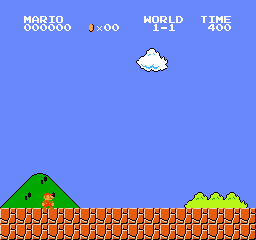

In [9]:
env.reset()
PIL.Image.fromarray(env.render())

In [10]:
print('Observation Spec:')
print(GymWrapper(env).time_step_spec().observation)

Observation Spec:
ArraySpec(shape=(240, 256, 3), dtype=dtype('uint8'), name=None)


In [11]:
env = FlattenObservation(env)
print('Flattened Observation Spec:')
print(GymWrapper(env).time_step_spec().observation)
# need to flatten observation space in order to be used below

Flattened Observation Spec:
ArraySpec(shape=(184320,), dtype=dtype('uint8'), name=None)


In [12]:
print(GymWrapper(env).time_step_spec().observation)

ArraySpec(shape=(184320,), dtype=dtype('uint8'), name=None)


In [13]:
print('Reward Spec:')
print(GymWrapper(env).time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [14]:
print('Action Spec:')
print(GymWrapper(env).action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=255)


In [15]:
time_step = GymWrapper(env).reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = GymWrapper(env).step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': (array([104, 136, 252, ..., 228,  92,  16], dtype=uint8), {})})
Next time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': (array([104, 136, 252, ..., 228,  92,  16], dtype=uint8), {})})


In [16]:
train_py_env = GymWrapper(env)
eval_py_env = GymWrapper(env)
# using GymWrapper function above in order to be able to use tensorflow next

dir(train_py_env)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_action_spec',
 '_current_time_step',
 '_get_action_spec',
 '_get_observation_spec',
 '_gym_env',
 '_handle_auto_reset',
 '_observation_spec',
 '_reset',
 '_step',
 'action_spec',
 'batch_size',
 'batched',
 'close',
 'current_time_step',
 'discount_spec',
 'get_info',
 'get_state',
 'observation_spec',
 'render',
 'reset',
 'reward_spec',
 'seed',
 'set_state',
 'should_reset',
 'step',
 'time_step_spec']

In [17]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)
# converting into tensorflow enviornment

In [18]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(GymWrapper(env).action_spec())
# need GymWrapper(env) rather than just env
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

print(q_net)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [20]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [21]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [22]:
example_environment = tf_py_environment.TFPyEnvironment(GymWrapper(env))

In [23]:
dir(example_environment)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_action_spec',
 '_batch_size',
 '_check_dims',
 '_current_time_step',
 '_env',
 '_execute',
 '_lock',
 '_pool',
 '_render_shape',
 '_reset',
 '_step',
 '_time_step',
 '_time_step_dtypes',
 '_time_step_from_numpy_function_outputs',
 '_time_step_spec',
 'action_spec',
 'batch_size',
 'batched',
 'close',
 'current_time_step',
 'observation_spec',
 'pyenv',
 'render',
 'reset',
 'reward_spec',
 'step',
 'time_step_spec']

In [24]:
time_step = example_environment.reset()

In [25]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([11])>, state=(), info=())

In [26]:
done = False
score = 0
current_time = 400 # start time for game
coins_total = 0  # start number of coins at zero
prev_x_pos, prev_y_pos = 0, 0


def return_reward(info):
  """

  Args:
    info:

  Returns:
    reward
  """
  # reward function that returns rewards/penalties for actions

  reward = 0
  coins, flag_get = info['coins'], info['flag_get']
  time_left, status =  info['time'], info['status']
  x_pos, y_pos = info['x_pos'], info['y_pos']
  # get info for actions

  if coins > coins_total:
    reward += 1
  # increase reward for Mario getting a coin

  if status == 'fireball':
    reward += 2
  elif status == 'tall':
    reward += 1
  else:
    reward += 0
  # increases reward for Mario being more powerful

  if flag_get == True:
    reward += 100
  # increases reward for Mario reaching flag at the end of the level

  if x_pos == prev_x_pos and y_pos == prev_y_pos:
    reward -= 2
  else:
    reward += 1
  # decrease reward for Mario staying still/increase it for moving

  reward  -= (400 - time_left)/400
  # decrease reward for time running out

  return reward

In [27]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for i in range(num_episodes):

    done = False
    current_time = 400
    coins_total = 0  # start number of coins at zero
    prev_x_pos, prev_y_pos = 0, 0
    time_step = environment.reset()
    episode_return = 0.0

    while current_time > 0:
      action_step = policy.action(time_step)
      obs, reward, terminated, truncated, info = env.step(action_step.action)
      coins_total = info['coins']
      current_time = info['time']
      # get current time and current total number of coins
      # episode_return += return_reward(info) <-- # this is using reward function
      # rather than built in reward
      episode_return += reward
      if current_time == 0 or info['flag_get'] == True or info['life'] == 0:
        done = True
      # end the game if these conditions are met
      done = terminated or truncated
      if done:
        env.reset()
      prev_x_pos, prev_y_pos = info['x_pos'], info['y_pos']
      # save Mario position

    print("Episode ",i," finished") # time checking step
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return


In [138]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)
# assume this will take ~15 minutes

Episode  0  finished
Episode  1  finished
Episode  2  finished
Episode  3  finished
Episode  4  finished
Episode  5  finished
Episode  6  finished
Episode  7  finished
Episode  8  finished
Episode  9  finished


137.8

In [28]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [29]:
agent.collect_data_spec

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': TensorSpec(shape=(184320,), dtype=tf.uint8, name=None),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(0), maximum=array(255)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

In [30]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

**TODO** Fix below section

In [31]:

py_driver.PyDriver(
    GymWrapper(env),
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

ValueError: time_step and time_step_spec structures do not match:
  TimeStep(
{'step_type': ., 'reward': ., 'discount': ., 'observation': (., {})})
vs.
  TimeStep(
{'step_type': ., 'reward': ., 'discount': ., 'observation': .})
Values:
  TimeStep(
{'step_type': <tf.Tensor 'time_step:0' shape=(1,) dtype=int32>,
 'reward': <tf.Tensor 'time_step_1:0' shape=(1,) dtype=float32>,
 'discount': <tf.Tensor 'time_step_2:0' shape=(1,) dtype=float32>,
 'observation': (<tf.Tensor 'time_step_3:0' shape=(1, 184320) dtype=uint8>, {})})
vs.
  TimeStep(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': TensorSpec(shape=(184320,), dtype=tf.uint8, name=None)}).

In [ ]:
iter(replay_buffer.as_dataset()).next()

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

In [ ]:
iterator = iter(dataset)
print(iterator)

In [ ]:
iterator.next()

In [32]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode  0  finished
Episode  1  finished
Episode  2  finished
Episode  3  finished
Episode  4  finished
Episode  5  finished
Episode  6  finished
Episode  7  finished
Episode  8  finished
Episode  9  finished


AttributeError: 'EnvCompatibility' object has no attribute 'batched'

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

In [ ]:
create_policy_eval_video(random_policy, "random-agent")